In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf

# Загрузка и подготовка данных

In [2]:
instruments = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'LTCUSDT', 'EOSUSDT']
files = ['close.csv', 'open.csv', 'low.csv', 'high.csv', 'volume.csv']
columns = ['close', 'open', 'low', 'high', 'volume']

In [3]:
series_per_ccys = {k: [] for k in instruments}

for file in files:
    frame = pd.read_csv('data/' + file,parse_dates=True,index_col=0)
    for instrument in instruments:
        series_per_ccys[instrument].append(frame[instrument])
df_per_ccys = {k: pd.DataFrame(series_per_ccys[k], columns).transpose() for k in instruments}
df_per_ccys['BTCUSDT'].head()

,close,open,low,high,volume
2020-01-01 00:00:00,7186.68,7184.42,7183.14,7196.25,51.642812
2020-01-01 00:01:00,7184.03,7186.68,7182.20,7188.06,7.248148
2020-01-01 00:02:00,7182.43,7184.03,7180.26,7184.71,11.681677
2020-01-01 00:03:00,7185.94,7182.43,7182.49,7188.94,10.025391
2020-01-01 00:04:00,7179.78,7185.94,7178.64,7185.54,14.911105


Пока что будем работать только с `BTCUSDT`:

In [4]:
df = df_per_ccys['BTCUSDT']

Добавляем доходности:

In [5]:
df['return'] = (df['open'] - df['close']) / (df['open'])
df.head()

,close,open,low,high,volume,return
2020-01-01 00:00:00,7186.68,7184.42,7183.14,7196.25,51.642812,-0.000315
2020-01-01 00:01:00,7184.03,7186.68,7182.20,7188.06,7.248148,0.000369
2020-01-01 00:02:00,7182.43,7184.03,7180.26,7184.71,11.681677,0.000223
2020-01-01 00:03:00,7185.94,7182.43,7182.49,7188.94,10.025391,-0.000489
2020-01-01 00:04:00,7179.78,7185.94,7178.64,7185.54,14.911105,0.000857


Объявляем функцию для ресеплирования:

In [6]:
def resample(freq, dataframe: pd.DataFrame) -> pd.DataFrame:
  return dataframe.groupby(pd.Grouper(freq=freq)).agg({'open':'first', 'close':'last', 'high':'max', 'low':'min', 'volume': 'sum', 'return': 'std'}).rename(columns={'return': 'vol'})

Пока что будем работать только с часовыми данными, выбрасываем точки, где не было торгов, волатильность за час получаем умножением на корень из количества периодов (60):

In [7]:
df_1h = resample('1h', df)
df_1h['return'] = (df_1h['open'] - df_1h['close']) / (df_1h['open'])
df_1h['vol'] = df_1h['vol'] * np.sqrt(60.0)
df_1h = df_1h.dropna()
df_1h = df_1h[df_1h['volume'] != 0]
df_1h.head()

,open,close,high,low,volume,vol,return
2020-01-01 00:00:00,7184.42,7177.02,7196.25,7175.46,511.814901,0.002777,0.001030
2020-01-01 01:00:00,7177.02,7216.27,7230.00,7175.71,883.052603,0.004275,-0.005469
2020-01-01 02:00:00,7216.27,7242.85,7244.87,7211.41,655.156809,0.002741,-0.003683
2020-01-01 03:00:00,7242.85,7225.01,7245.00,7220.00,783.724867,0.003049,0.002463
2020-01-01 04:00:00,7225.01,7217.27,7230.00,7215.03,467.812578,0.001920,0.001071


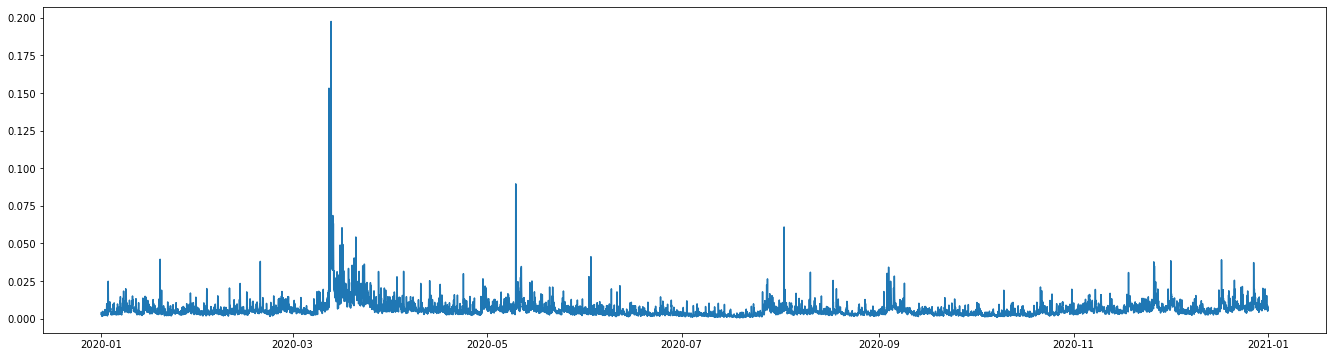

In [8]:
plt.figure(figsize=(23,6))
plt.plot(df_1h['vol'])
plt.show()

In [9]:
def ewma(data, alpha):
  sum = 0.0
  for x in data:
    sum = sum * alpha + x * (1.0 - alpha)
  return sum


# Индикатор Average True Range.

Подробнее на БКС Экспресс:
https://bcs-express.ru/novosti-i-analitika/indikator-average-true-range-opredeliaem-volatil-nost


In [10]:
def attach_ATR(df, n):
    true_range = pd.concat([abs(df['high'] - df['close'].shift(1)),
                            abs(df['high'] - df['low']), 
                            abs(df['low'] - df['close'].shift(1))]).max(level=0)

    df['atr'] = np.nan
    df['atr'][0] = true_range[0]
    
    for i in range(1, len(df)):
        df['atr'][i] = (df['atr'][i-1] * (n-1) + true_range[i]) / n
        

In [11]:
attach_ATR(df_1h, 14)

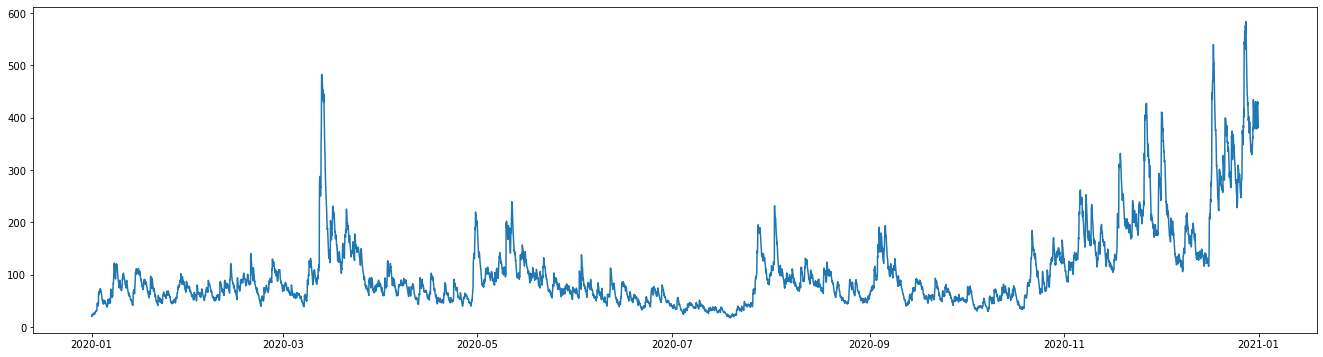

In [12]:
plt.figure(figsize=(23,6))
plt.plot(df_1h['atr'])
plt.show()


# Relative Strength index

Подробнее на БКС Экспресс:
https://bcs-express.ru/novosti-i-analitika/indeks-otnositel-noi-sily-rsi-relative-strength-index


In [13]:
def attach_RSI(df, n):
    df['rsi'] = np.nan
    
    close = df['close'] 
    
    for period_start_idx in range(n + 1, len(df)):
        
        up = []
        down = []
        
        for i in range(1, n + 1):
            diff = close[period_start_idx - i - 1] - close[period_start_idx - i]
            if diff > 0:
                up.append(diff)
            else:
                down.append(-diff)
        
        alpha = 2.0 / (n + 1)
        
        rs = ewma(up, alpha) / ewma(down, alpha)
        
        df['rsi'][period_start_idx] = 100.0 - 100.0 / (1.0 + rs)

In [14]:
attach_RSI(df_1h, 14)

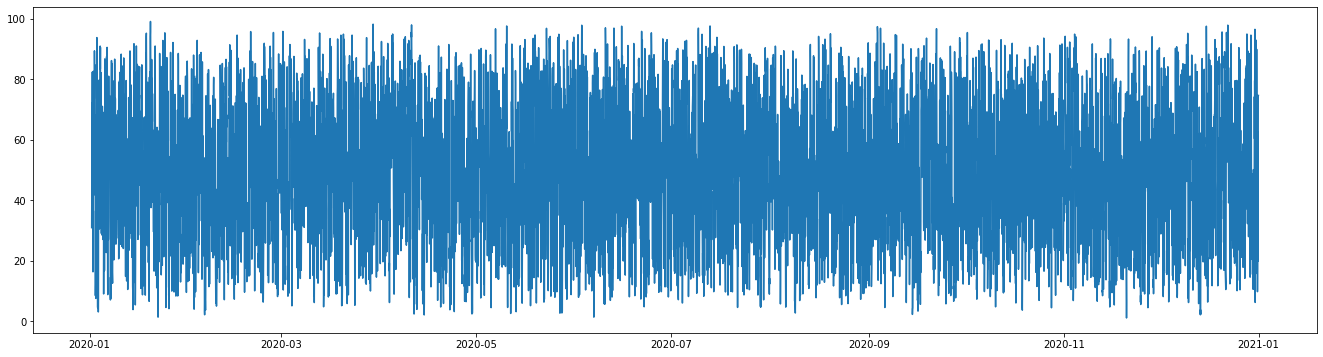

In [15]:
plt.figure(figsize=(23,6))
plt.plot(df_1h['rsi'])
plt.show()

#  Moving Average Convergence/Divergence

Подробнее на БКС Экспресс:
https://bcs-express.ru/novosti-i-analitika/indikator-macd-skol-ziashchie-srednie-v-udobnoi-upakovke


In [16]:
def attach_MACD(df, n1, n2, k):
    df['macd'] = np.nan
    
    close = df['close']
    
    sample_n1 = [np.nan] * len(df)
    alpha_n1 = 2.0 / (n1 + 1)
    for i in range(n1, len(df)):
        sample_n1[i] = ewma(close[i - n1:i], alpha_n1) 
    
    sample_n2 = [np.nan] * len(df)
    alpha_n2 = 2.0 / (n2 + 1)
    for i in range(n2, len(df)):
        sample_n2[i] = ewma(close[i - n2:i], alpha_n2) 
    
    diff = [np.nan] * len(df)
    for i in range(0, len(df)):
        diff[i] = sample_n1[i] - sample_n2[i]
    
    result = [np.nan] * len(df)
    alpha_k = 2.0 / (k + 1)
    for i in range(k, len(df)):
        df['macd'][i] = ewma(diff[i - k:i], alpha_k)
        

In [17]:
attach_MACD(df_1h, 12, 26, 9)

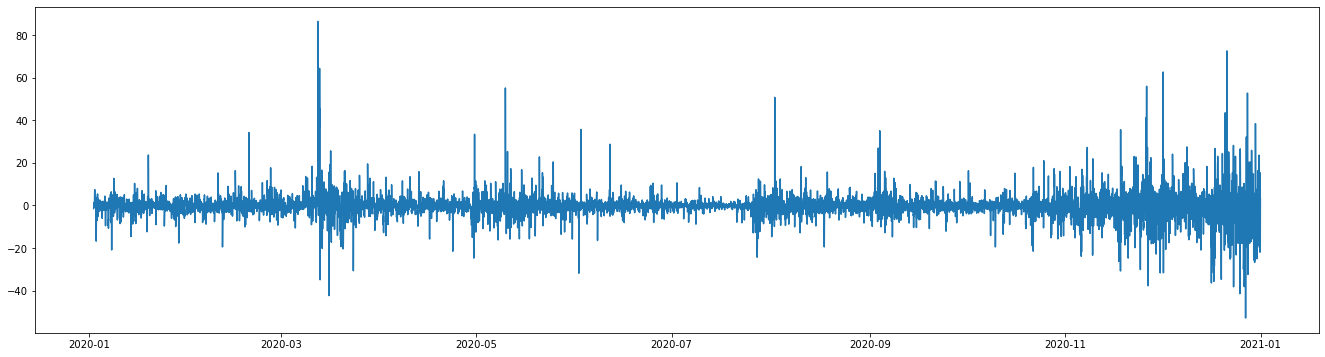

In [18]:
plt.figure(figsize=(23,6))
plt.plot(df_1h['macd'])
plt.show()